# Imports

In [ ]:
from pathlib import Path
import json
from typing import Union, Callable, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import wandb

# Select device

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Constants directories paths

In [ ]:
ROOT_DIR = Path.cwd().parent

MODELS_DIR = ROOT_DIR / "models"

DATA_DIR = ROOT_DIR / "data"
TRAIN_IMAGES_DIR = DATA_DIR / "train" / "simple_color_dataset" / "images"
TRAIN_LABELS_DIR = DATA_DIR / "train" / "simple_color_dataset" / "labels"

CLASS_TO_IMAGE_JSON_PATH = DATA_DIR / "classes" / "class_to_name.json"

TEST_IMAGES_DIR = DATA_DIR / "test"

In [4]:
with open(CLASS_TO_IMAGE_JSON_PATH, "r") as f:
    class_to_name = json.load(f)

In [5]:
class ColorDataset(Dataset):
    """Custom dataset for loading images and corresponding labels.

    Attributes:
        images_dir (Path): Directory containing image files.
        labels_dir (Path): Directory containing JSON label files.
        transform (Callable): Optional transformation to apply to images.
    """
    def __init__(
        self,
        images_dir: Union[Path, str],
        labels_dir: Union[Path, str],
        transform: Callable = None
    ) -> None:
        """Initialize the dataset.

        Args:
            images_dir (Union[Path, str]): Path to the directory with image files.
            labels_dir (Union[Path, str]): Path to the directory with JSON label files.
            transform (Callable, optional): Transformations to apply to the images. Defaults to None.
        """
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transform = transform

        # Collect list of image-label pairs
        self.data = self._collect_data()

    def _collect_data(self) -> List[Tuple[Path, Path]]:
        """Collect and validate image-label pairs.

        Returns:
            List[Tuple[Path, Path]]: List of tuples where each tuple contains paths to an image and its corresponding label file.

        Raises:
            ValueError: If the number of images and labels do not match or if filenames are inconsistent.
        """
        image_files = sorted(self.images_dir.glob("*.png"))
        label_files = sorted(self.labels_dir.glob("*.json"))

        if len(image_files) != len(label_files):
            raise ValueError("Number of images and JSON files do not match!")

        data = []
        for img_file, lbl_file in zip(image_files, label_files):
            if img_file.stem != lbl_file.stem:
                raise ValueError(f"Mismatch between {img_file.name} and {lbl_file.name}")

            data.append((img_file, lbl_file))

        return data

    def __len__(self) -> int:
        """Return the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, int]:
        """Retrieve a sample by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[Image.Image, int]: A tuple containing the image and its label.

        Raises:
            IndexError: If the index is out of range.
            ValueError: If the label file does not contain a 'class_id'.
        """
        if idx < 0 or idx >= len(self):
            raise IndexError("Index out of range")

        image_path, label_path = self.data[idx]

        # Load image
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        # Load label
        with open(label_path, 'r') as f:
            label_data = json.load(f)
            label = label_data.get('class_id')

        if label is None:
            raise ValueError(f"Missing 'class_id' in label file: {label_path}")

        return image, label


In [6]:
transform = transforms.Compose([transforms.ToTensor()]) # Convert image to tensor [C, H, W]

dataset = ColorDataset(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, transform=transform)

train_size = int(0.8 * len(dataset))  # 80% for train
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Showing images from train loader

tensor(30)


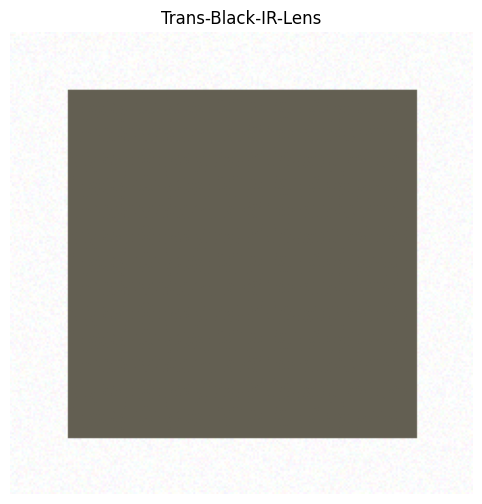

In [7]:
def show_images_with_classes(images, labels, class_to_name_map) -> None:
    plt.figure(figsize=(12, 6))
    plt.imshow(images[0,:,:,:].squeeze(0).permute(1,2,0))
    plt.axis('off')
    
    class_names = [class_to_name_map[str(label.item())] for label in labels]
    print(labels[0])
    plt.title(class_names[0], fontsize=12)
    plt.show()


for batch_idx, (images, labels) in enumerate(train_loader):

    show_images_with_classes(images, labels, class_to_name)
    break

In [ ]:
class ColorClassifier(nn.Module):
    def __init__(self, num_classes=133):
        super(ColorClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # (240x240x3) -> (120x120x32)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # (120x120x32) -> (60x60x64)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # (60x60x64) -> (30x30x128)
        self.bn3 = nn.BatchNorm2d(128)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)) # (30x30x128) -> (7x7x128)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))  
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  

        x = self.adaptive_pool(x)  

        x = x.view(-1, 128 * 7 * 7) # flatten for fc

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)

        x = self.fc3(x)
        return x


In [11]:
model = ColorClassifier(num_classes=133).to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 30

In [ ]:
train_losses = []
val_losses = []
train_accuracies_list = []
val_accuracies_list = []
train_precision_list, val_precision_list = [], []
train_recall_list, val_recall_list = [], []
train_f1_list, val_f1_list = [], []

best_val_loss = float('inf')
best_weights = None


In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()


def precision_score(y_true, y_pred, average='macro'):
    classes = set(y_true)
    precision_per_class = []
    for cls in classes:
        tp = sum((y_pred == cls) & (y_true == cls))  # True Positives
        fp = sum((y_pred == cls) & (y_true != cls))  # False Positives
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precision_per_class.append(precision)
    
    if average == 'macro':
        return sum(precision_per_class) / len(precision_per_class)
    else:
        raise ValueError("Only 'macro' averaging is supported.")

def recall_score(y_true, y_pred, average='macro'):

    classes = set(y_true)
    recall_per_class = []
    for cls in classes:
        tp = sum((y_pred == cls) & (y_true == cls))  # True Positives
        fn = sum((y_pred != cls) & (y_true == cls))  # False Negatives
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recall_per_class.append(recall)
    
    if average == 'macro':
        return sum(recall_per_class) / len(recall_per_class)
    else:
        raise ValueError("Only 'macro' averaging is supported.")

def f1_score(y_true, y_pred, average='macro'):
    precision = precision_score(y_true, y_pred, average)
    recall = recall_score(y_true, y_pred, average)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


In [ ]:
wandb.init(
    project="color_prediction",
    name="Classic",
    config={
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": optimizer.param_groups[0]['lr']
    }
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kozhukovv. Use `wandb login --relogin` to force relogin


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    y_train_true, y_train_pred = [], []

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_corrects += calculate_accuracy(outputs, labels)
        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    avg_train_acc = running_corrects / len(train_loader)
    train_precision = precision_score(y_train_true, y_train_pred, average='macro')
    train_recall = recall_score(y_train_true, y_train_pred, average='macro')
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')

    # Validation loop
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_running_corrects += calculate_accuracy(outputs, labels)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_acc = val_running_corrects / len(val_loader)
    val_precision = precision_score(y_val_true, y_val_pred, average='macro')
    val_recall = recall_score(y_val_true, y_val_pred, average='macro')
    val_f1 = f1_score(y_val_true, y_val_pred, average='macro')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights = model.state_dict()
        torch.save(best_weights, "best_model_weights.pth")

    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_accuracy": avg_train_acc,
        "val_accuracy": avg_val_acc,
        "train_precision": train_precision,
        "val_precision": val_precision,
        "train_recall": train_recall,
        "val_recall": val_recall,
        "train_f1": train_f1,
        "val_f1": val_f1,
        "weight_max": max([w.max().item() for w in model.parameters()]),
        "weight_min": min([w.min().item() for w in model.parameters()]),
        "weight_mean": sum([w.mean().item() for w in model.parameters()]) / len(list(model.parameters()))
    })


    print(f"Epoch {epoch + 1}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}")

wandb.finish()

Epoch 1: Train Loss 2.7550, Val Loss 1.2444
Epoch 2: Train Loss 1.2397, Val Loss 0.6713
Epoch 3: Train Loss 0.8974, Val Loss 0.5621
Epoch 4: Train Loss 0.6905, Val Loss 0.5897
Epoch 5: Train Loss 0.6480, Val Loss 0.4166
Epoch 6: Train Loss 0.5655, Val Loss 0.4269
Epoch 7: Train Loss 0.5336, Val Loss 0.4294
Epoch 8: Train Loss 0.5333, Val Loss 0.6470
Epoch 9: Train Loss 0.4768, Val Loss 0.4030
Epoch 10: Train Loss 0.4331, Val Loss 0.2162
Epoch 11: Train Loss 0.4016, Val Loss 0.3304
Epoch 12: Train Loss 0.3876, Val Loss 0.2689
Epoch 13: Train Loss 0.4010, Val Loss 0.2498
Epoch 14: Train Loss 0.3609, Val Loss 0.2053
Epoch 15: Train Loss 0.3734, Val Loss 0.4627
Epoch 16: Train Loss 0.3677, Val Loss 0.2264
Epoch 17: Train Loss 0.3323, Val Loss 0.2226
Epoch 18: Train Loss 0.3702, Val Loss 0.2139
Epoch 19: Train Loss 0.3309, Val Loss 0.1739
Epoch 20: Train Loss 0.3566, Val Loss 0.4835
Epoch 21: Train Loss 0.3544, Val Loss 0.2194
Epoch 22: Train Loss 0.3336, Val Loss 0.3376
Epoch 23: Train Los

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▆▆▇▇▇▇▇▇▇███████████████████
train_f1,▁▄▆▆▆▇▇▇▇▇▇█▇█████████████████
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▄▅▆▆▇▇▇▇▇▇█▇█████████████████
train_recall,▁▅▆▆▇▇▇▇▇▇▇█▇█████████████████
val_accuracy,▁▄▄▃▅▅▄▅▅▇▆▆▇▇▅▇▇▇█▅▇▆▅▆▇▇█▇▆█
val_f1,▁▄▅▃▅▅▄▅▅█▆▇▇▇▅▇▇██▅▇▆▅▆▇██▇▇█
val_loss,█▄▄▄▃▃▃▄▃▁▂▂▂▁▃▂▁▁▁▃▁▂▄▂▁▁▁▁▃▁
val_precision,▁▄▅▃▅▅▄▅▅█▆▇▇▇▅▇▇██▅▇▆▅▆▇██▇▇█
val_recall,▁▄▅▃▅▅▄▅▅█▆▇▇▇▅▇▇██▅▇▆▅▆▇██▇▇█


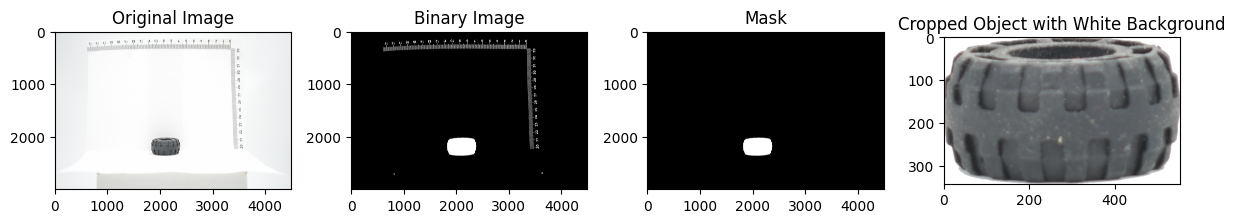

In [ ]:
def extract_object_with_white_background(image_path):

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, binary = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_object = image[y:y+h, x:x+w]
    mask_cropped = mask[y:y+h, x:x+w]

    white_background = np.full_like(cropped_object, 255)
    result = np.where(mask_cropped[:, :, None] == 255, cropped_object, white_background)

    return image, binary, mask, result

image_path = DATA_DIR / "test" / "1-1.JPG"

original, binary, mask, result = extract_object_with_white_background(image_path)

# Визуализация результатов
plt.figure(figsize=(12, 8))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

plt.subplot(1, 4, 2)
plt.title("Binary Image")
plt.imshow(binary, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.subplot(1, 4, 4)
plt.title("Cropped Object with White Background")
plt.imshow(img)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2923364/864271364.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Загружаем веса модели


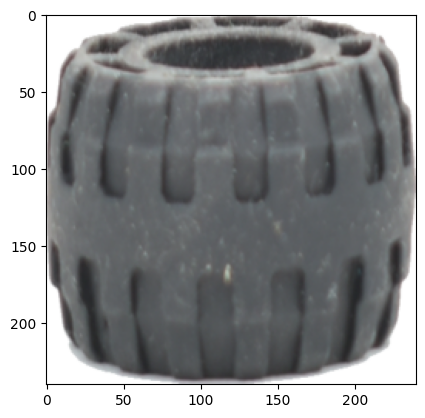

Предсказанный класс: Class_58
Уверенность: 0.8882


In [ ]:
def predict_image(model, image_path, class_names):
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
    ])

    image = Image.fromarray(image_path)
    input_tensor = preprocess(image).unsqueeze(0)

    input_tensor = input_tensor.to(DEVICE)
    model = model.to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    predicted_class = class_names[predicted_class_idx]
    confidence = probabilities[0, predicted_class_idx].item()
    plt.imshow(input_tensor.cpu().squeeze(0).permute(1,2,0))
    plt.show()
    return predicted_class, confidence

# Пример использования
if __name__ == "__main__":
    model_path = MODELS_DIR / "best_model_weights.pth"
    model = ColorClassifier(num_classes=133)
    model.load_state_dict(torch.load(model_path))

    # Список имен классов
    class_names = [f"Class_{i}" for i in range(133)]

    # Путь к изображению
    image_path = DATA_DIR / "test" / "28-3.JPG"

    # Выполняем предсказание
    predicted_class, confidence = predict_image(model, img, class_names)
    print(f"Предсказанный класс: {predicted_class}")
    print(f"Уверенность: {confidence:.4f}")

In [ ]:
scripted_model = torch.jit.script(model)

scripted_model.save("model_architecture.pt")